---
### Coupling two probability distributions with high probability of equality  
---

**Course:** *Simulation and Monte Carlo Methods* (2nd Semester, ENSAE Paris)  
**Authors:** Piero PELOSI, Omar EL MAMOUNE, Sarakpy NY  
**Supervisor:** Yvann LE FAY

---

In [62]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

---
#### I. Quick introduction

Given two probability distributions $p$ and $q$, we are interested in constructing a joint distribution (coupling) for $(X,Y)$ such that $X \sim p$, $Y \sim q$, and $P(X=Y)$ is as large as possible. The paper [*The Coupled Rejection Sampler*](https://arxiv.org/abs/2201.09585) proposes a method to achieve this goal and shows how it can be applied to the case of two multivariate Gaussian distributions with different covariance matrices.

This project consists in implementing the proposed approach and comparing it with a simpler, classical algorithm known as Thorisson’s algorithm (Appendix 1 in the paper). We will explain why Thorisson’s algorithm is valid, how it relates to rejection sampling, and then examine several scenarios of increasing dimension. Since the running time of these algorithms is itself a random variable, we will also comment on its distribution and practical implications.

If time permits, we may additionally explore how such a coupling can be embedded in a random-walk Metropolis setting (as in Section 5.3 of the reference paper), and attempt to replicate some of those experiments. 

---
#### II. The coupled rejection-sampling method

Let $p$ and $q$ be two probability densities defined on $\chi$. We define a diagonal coupling of $p$ and $q$ in the following way.

**Definition 1** (Diagonal coupling). *A pair of random variables $(X, Y)$ defined on the same probability space and taking values in $\chi$ is a diagonal coupling of the probability densities $p$ and $q$ if and only if it is a coupling, that is, if*

$$
\mathbb{P}(X \in A) = \int_A p(x)\,dx, \quad \mathbb{P}(Y \in A) = \int_A q(x)\,dx,
$$

*for all measurable sets $A \subset \chi$, and if $\mathbb{P}(X = Y) > 0$.*

With this definition, a maximal coupling (Thorisson, 2000; Lindvall, 2002) is a diagonal coupling with maximal mass on the diagonal event $\{X = Y\}$.

In order to construct the acceptance-rejection scheme, we need the following definition.

**Definition 2** (Dominating pair). *Let $(\hat{p}, \hat{q})$ be a pair of probability densities. We say that it dominates $(p, q)$ (or that $(p, q) \preceq (\hat{p}, \hat{q})$) if and only if there exists $1 \leq M(p, \hat{p}) < \infty$ and $1 \leq M(q, \hat{q}) < \infty$ such that for any $x \in \mathbb{R}^d$ we have*

$$
p(x) \leq M(p, \hat{p})\, \hat{p}(x), \quad q(x) \leq M(q, \hat{q})\, \hat{q}(x).
$$

Now, suppose that we have a diagonal coupling $\hat{\Gamma}$ of $\hat{p}$ and $\hat{q}$ dominating the independent coupling $(p \otimes q)(x, y) = p(x)\, q(y)$. It turns out that we can produce samples from a diagonal coupling $\Gamma$ with marginals $p$ and $q$ by using an acceptance-rejection scheme with the coupling $\hat{\Gamma}$ as the proposal. 

Algorithm **1** shows how to do this and will be implemented below.

<div align="center">
    <img src="https://raw.githubusercontent.com/pieropls/MCProject.Coupling/main/Images/Rejection-coupling.algo.png" alt="Rejection-coupling of (p,q)" width="600"/>
</div>

In [ ]:
def rejection_coupling(p, q, hat_p, hat_q, sample_hat_gamma, sample_pq, M_p, M_q):
    A_x, A_y = 0, 0                          # Acceptance flags

    while A_x == 0 and A_y == 0:
        X1, Y1 = sample_hat_gamma()          # Sample from diagonal coupling hat_Gamma
        U = np.random.uniform(0, 1)

        if U < p(X1) / (M_p * hat_p(X1)):
            A_x = 1
        if U < q(Y1) / (M_q * hat_q(Y1)):
            A_y = 1

    X2, Y2 = sample_pq()                     # Sample from independent p ⊗ q

    X = A_x * X1 + (1 - A_x) * X2
    Y = A_y * Y1 + (1 - A_y) * Y2

    return X, Y

In [73]:
# Parameters
mu_p, sigma_p = 0.0, 1.0        # p ~ N(0, 1)
mu_q, sigma_q = 0.0, 2.0        # q ~ N(0, 4)
hat_sigma = 2.5

# Densities
p = lambda x: norm(loc=mu_p, scale=sigma_p).pdf(x)
q = lambda y: norm(loc=mu_q, scale=sigma_q).pdf(y)
hat_p = lambda x: norm(loc=mu_p, scale=hat_sigma).pdf(x)
hat_q = lambda y: norm(loc=mu_q, scale=hat_sigma).pdf(y)

# Constants
M_p = hat_sigma / sigma_p
M_q = hat_sigma / sigma_q

# Samplers
sample_hat_gamma = lambda: (norm(loc=mu_p, scale=hat_sigma).rvs(), norm(loc=mu_q, scale=hat_sigma).rvs())
sample_pq = lambda: (norm(loc=mu_p, scale=sigma_p).rvs(), norm(loc=mu_q, scale=sigma_q).rvs())

# Generate samples
n = 1000
X_values, Y_values = zip(*[rejection_coupling(p, q, hat_p, hat_q, sample_hat_gamma, sample_pq, M_p, M_q)
                           for _ in range(n)])

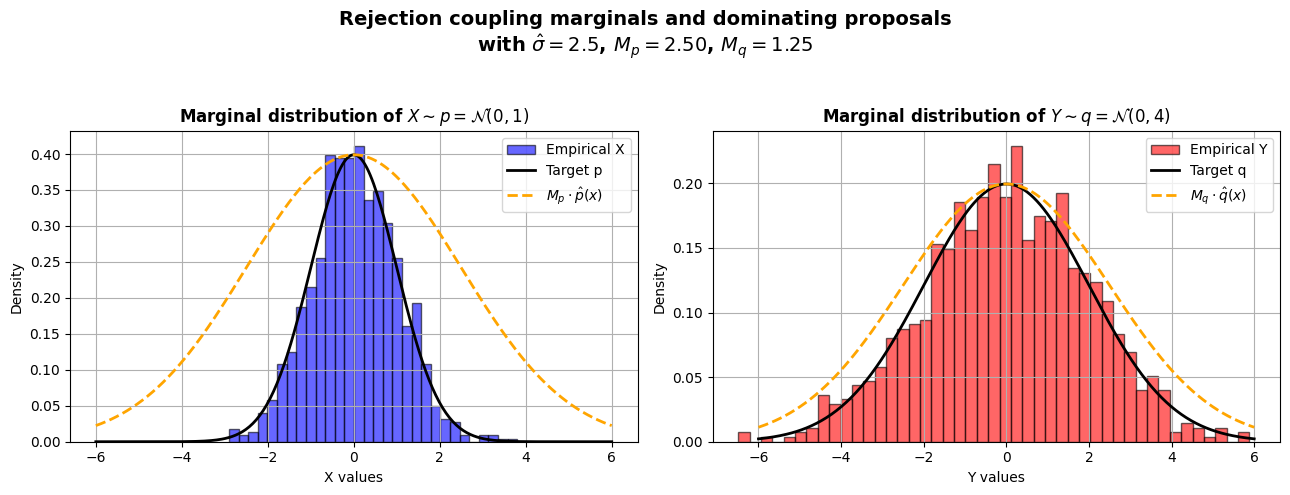

In [74]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
x_grid = np.linspace(-6, 6, 300)

# Scaled proposal curves
hat_p_scaled = lambda x: M_p * norm.pdf(x, mu_p, hat_sigma)
hat_q_scaled = lambda x: M_q * norm.pdf(x, mu_q, hat_sigma)

ax1.hist(X_values, bins=30, alpha=0.6, color='blue', edgecolor='black', density=True, label="Empirical X")
ax1.plot(x_grid, norm.pdf(x_grid, mu_p, sigma_p), color='black', linewidth=2, label="Target p")
ax1.plot(x_grid, hat_p_scaled(x_grid), color='orange', linestyle='--', linewidth=2, label=r"$M_p \cdot \hat{p}(x)$")
ax1.set_title(r"Marginal distribution of $X \sim p = \mathcal{N}(0, 1)$", fontweight='bold')
ax1.set_xlabel("X values")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid(True)

ax2.hist(Y_values, bins=45, alpha=0.6, color='red', edgecolor='black', density=True, label="Empirical Y")
ax2.plot(x_grid, norm.pdf(x_grid, mu_q, sigma_q), color='black', linewidth=2, label="Target q")
ax2.plot(x_grid, hat_q_scaled(x_grid), color='orange', linestyle='--', linewidth=2, label=r"$M_q \cdot \hat{q}(x)$")
ax2.set_title(r"Marginal distribution of $Y \sim q = \mathcal{N}(0, 4)$", fontweight='bold')
ax2.set_xlabel("Y values")
ax2.set_ylabel("Density")
ax2.legend()
ax2.grid(True)

plt.suptitle(
    rf"Rejection coupling marginals and dominating proposals" "\n"
    rf"with $\hat{{\sigma}} = {hat_sigma}$, $M_p = {M_p:.2f}$, $M_q = {M_q:.2f}$",
    fontsize=14,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---
#### III. The ensemble coupled rejection-sampling method

---
#### IV. The multidimensional Gaussian case

---
#### V. Thorisson algorithm
In this section, we implement the following version of the *Modified Thorisson algorithm*, found in the appendix, page 31.

<div align="center">
    <img src="https://raw.githubusercontent.com/pieropls/MCProject.Coupling/main/Images/Thorisson.algo.mod.png" alt="Modified Thorisson algorithm" width="600"/>
</div>

In [63]:
def thorisson_coupling(sample_p, pdf_p, sample_q, pdf_q, C):
    X = sample_p()
    U = np.random.uniform(0, 1)
    if U < min((pdf_q(X) / pdf_p(X)), C):
        Y = X
    else:
        A = 0
        while A != 1:
            U = np.random.uniform(0, 1)
            Z = sample_q()
            if U > min(1, C * pdf_p(Z) / pdf_q(Z)):
                A = 1
            Y = Z
    return X, Y

In [77]:
# Parameters
mu_p, sigma_p = 0.0, 1.0
mu_q, sigma_q = 0.0, 2.0
C = 1.0

# Distributions
sample_p = lambda: norm(loc=mu_p, scale=sigma_p).rvs()
pdf_p = lambda x: norm(loc=mu_p, scale=sigma_p).pdf(x)

sample_q = lambda: norm(loc=mu_q, scale=sigma_q).rvs()
pdf_q = lambda x: norm(loc=mu_q, scale=sigma_q).pdf(x)

# # Generate samples
n = 1000
np.random.seed(87)
results = [thorisson_coupling(sample_p, pdf_p, sample_q, pdf_q, C) for _ in range(n)]
X_values, Y_values = zip(*results)

# Match analysis
matches = [x == y for x, y in zip(X_values, Y_values)]
match_count = sum(matches)
match_percentage = (match_count / n) * 100

print(f"Number of matches (X = Y): {match_count} out of {n}.")
print(f"Percentage of matches: {match_percentage:.2f}%.")

Number of matches (X = Y): 681 out of 1000.
Percentage of matches: 68.10%.


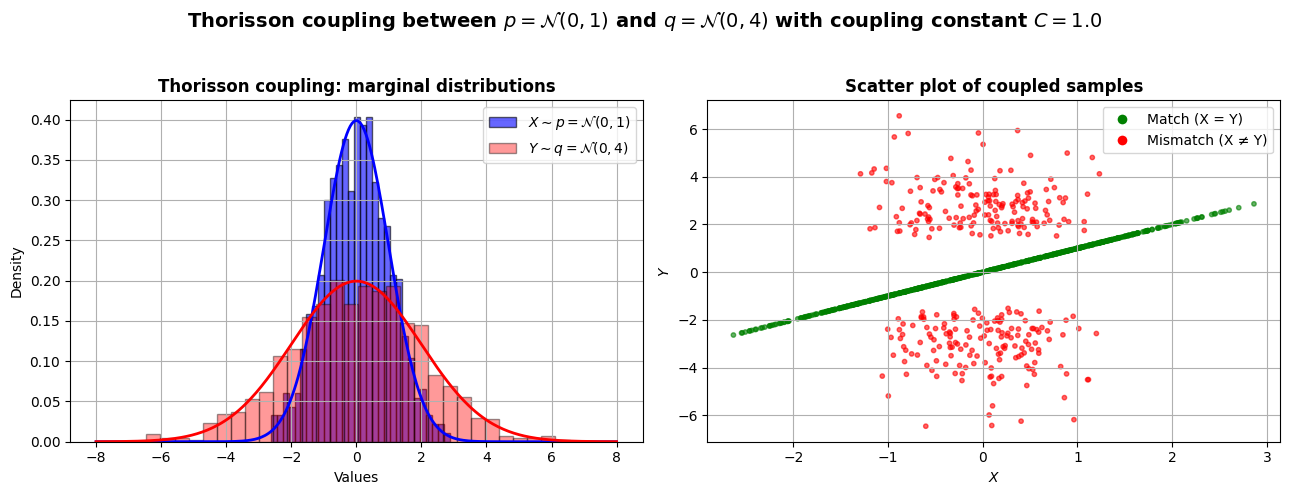

In [84]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
x_grid = np.linspace(-8, 8, 300)

# Histogram of marginals
ax1.hist(X_values, bins=30, alpha=0.6, color='blue', edgecolor='black', label=r"$X \sim p = \mathcal{N}(0, 1)$", density=True)
ax1.hist(Y_values, bins=30, alpha=0.4, color='red', edgecolor='black', label=r"$Y \sim q = \mathcal{N}(0, 4)$", density=True)
ax1.plot(x_grid, norm(loc=mu_p, scale=sigma_p).pdf(x_grid), color='blue', linestyle='-', linewidth=2)
ax1.plot(x_grid, norm(loc=mu_q, scale=sigma_q).pdf(x_grid), color='red', linestyle='-', linewidth=2)
ax1.set_title("Thorisson coupling: marginal distributions", fontweight='bold')
ax1.set_xlabel("Values")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid(True)

# Scatter plot of (X, Y) with match
colors = ['green' if m else 'red' for m in matches]
ax2.scatter(X_values, Y_values, c=colors, alpha=0.6, s=10)
ax2.set_title("Scatter plot of coupled samples", fontweight='bold')
ax2.set_xlabel("$X$")
ax2.set_ylabel("$Y$")
ax2.grid(True)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Match (X = Y)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Mismatch (X ≠ Y)')
]
ax2.legend(handles=legend_elements)

plt.suptitle(
    rf"Thorisson coupling between $p = \mathcal{{N}}(0, 1)$ and $q = \mathcal{{N}}(0, 4)$"
    rf" with coupling constant $C = {C}$",
    fontsize=14, fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

*Why is Thorisson’s algorithm valid? How does it relates to rejection sampling?*